In [1]:
import yfinance as yf
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller, coint
import statsmodels.api as sm
import pandas_ta as ta

from performance_indicator import *
from trading_computation import *
from plotting_computation import *

In [2]:
LEVERAGE = 10
INITIAL_CAP = 200000

## 1. Time Series Prep

- The adjusted closing price amends a stock's closing price to reflect that stock's value after accounting for any corporate actions. It is often used when examining historical returns or doing a detailed analysis of past performance.

In [3]:
end_date = datetime(2019, 12, 31)
start_date = datetime(2014, 1, 1)

# Download data as dataframe
ETF = yf.download('SPTL', start=start_date, end=end_date).reset_index()
EFFR = web.DataReader('EFFR', 'fred', start_date, end_date).dropna().reset_index().rename({'DATE':'Date'}, axis = 1)

[*********************100%***********************]  1 of 1 completed


In [4]:
# The EFFR data will be Nan at weekends or some other federal holidays
# The weekends are not tradings days and hence they are dropped. Otherwise, use forward fill method
# Assuing the EFFR data to the same as the previous day
df = pd.merge(left = ETF, right = EFFR, on = 'Date', how = 'left').ffill(axis = 0)

df = df[['Date', 'Close', 'EFFR']]

In [5]:
df['EFFR'] = pd.to_numeric(df['EFFR'], errors='coerce')
df['EFFR'] = df['EFFR'] / 100
# Adjust the annual risk-free rate to make it a daily rate
df['Daily_EFFR'] = df['EFFR']/(252*100)
df.head()

,Date,Close,EFFR,Daily_EFFR
0,2014-01-02,30.055,0.0008,3.174603e-08
1,2014-01-03,30.035,0.0008,3.174603e-08
2,2014-01-06,30.160,0.0008,3.174603e-08
3,2014-01-07,30.260,0.0007,2.777778e-08
4,2014-01-08,30.150,0.0007,2.777778e-08


In [6]:
# Calculate the daily execess return per unit SPTL
df['Daily_return'] = df['Close'].pct_change(1, fill_method='ffill')
df['Daily_excess_return'] = df['Close'].pct_change(1, fill_method='ffill') - df['Daily_EFFR']
df['Daily_excess_leverage_return'] = df['Daily_excess_return'] * LEVERAGE
df.iloc[196]

Date                            2014-10-13 00:00:00
Close                                     35.040001
EFFR                                         0.0009
Daily_EFFR                                      0.0
Daily_return                               0.005885
Daily_excess_return                        0.005885
Daily_excess_leverage_return               0.058849
Name: 196, dtype: object

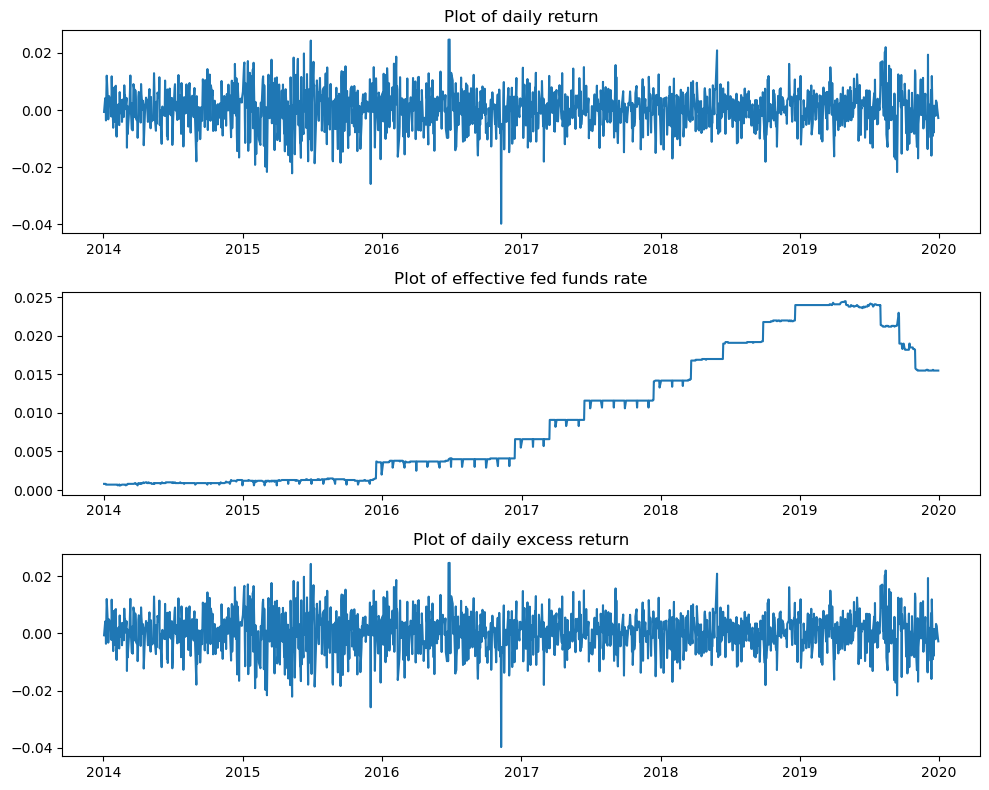

In [7]:
fig, ax = plt.subplots(3, 1, figsize = (10, 8))

ax[0].plot(df['Date'], df['Daily_return'])
ax[0].set_title('Plot of daily return')
ax[1].plot(df['Date'], df['EFFR'])
ax[1].set_title('Plot of effective fed funds rate')
ax[2].plot(df['Date'], df['Daily_excess_return'])
ax[2].set_title('Plot of daily excess return')
plt.tight_layout()

In [8]:
df

,Date,Close,EFFR,Daily_EFFR,Daily_return,Daily_excess_return,Daily_excess_leverage_return
0,2014-01-02,30.055000,0.0008,3.174603e-08,NaN,NaN,NaN
1,2014-01-03,30.035000,0.0008,3.174603e-08,-0.000665,-0.000665,-0.006655
2,2014-01-06,30.160000,0.0008,3.174603e-08,0.004162,0.004162,0.041618
3,2014-01-07,30.260000,0.0007,2.777778e-08,0.003316,0.003316,0.033156
4,2014-01-08,30.150000,0.0007,2.777778e-08,-0.003635,-0.003635,-0.036352
...,...,...,...,...,...,...,...
1504,2019-12-23,39.160000,0.0155,6.150794e-07,-0.002039,-0.002039,-0.020394
1505,2019-12-24,39.290001,0.0155,6.150794e-07,0.003320,0.003319,0.033191
1506,2019-12-26,39.389999,0.0155,6.150794e-07,0.002545,0.002545,0.025445
1507,2019-12-27,39.419998,0.0155,6.150794e-07,0.000762,0.000761,0.007610


## 2. Trading Strategies

### Strategy: LSTM Strategy

In [9]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import load_model

In [10]:
data = df.copy()
# Adding indicators
data['RSI']=ta.rsi(data.Close, length=15)
data['EMAF']=ta.ema(data.Close, length=20)
data['EMAM']=ta.ema(data.Close, length=50)

data.dropna(inplace=True)
data.reset_index(inplace = True)
dataset = data[['Close', 'RSI', 'EMAF', 'EMAM']]

In [11]:
dataset.head()

,Close,RSI,EMAF,EMAM
0,31.805000,60.627831,31.428095,31.179300
1,31.590000,54.966265,31.443515,31.195406
2,31.665001,56.485040,31.464609,31.213822
3,31.440001,50.960802,31.462265,31.222691
4,31.379999,49.575492,31.454430,31.228860


In [12]:
# Create a function to create a dataset with 60 timesteps
def create_dataset(dataset, time_step=60, y_colume_index=0):
    X, Y = [], []
    if not isinstance(dataset, np.ndarray):
        dataset = np.array(dataset).reshape(len(dataset), -1)

    if len(dataset.shape) == 1:
        dataset = dataset.reshape(-1, 1)
        
    # If we have 5 days of data and we want to look back 2 days
    # x1 = [d1, d2], y1 = [d3];
    # x2 = [d2, d3], y2 = [d4]; 
    # x3 = [d3, d4], y3 = [d5];
    for i in range(len(dataset) - time_step):
        
        # Slice from index i to index i + timestep, excluding (i + time_step)
        X.append(dataset[i:(i+time_step), :])
        Y.append(dataset[i + time_step, y_colume_index])
    return np.array(X), np.array(Y)


scalar = MinMaxScaler()
scaled_dataset = scalar.fit_transform(dataset)
# Create the dataset
time_step = 6
X, y = create_dataset(dataset, time_step, y_colume_index=0)

# The shape should be, (number of sequence, number of days to look back, number of columns)
print(X.shape)
print(y.shape)



(1454, 6, 4)
(1454,)


In [13]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1163, 6, 4)
(291, 6, 4)
(1163,)
(291,)


In [44]:

def train_lstm(seed):
    tf.random.set_seed(seed)
    # Build the LSTM model
    model = Sequential()
    # Return sequence: Boolean. Whether to return the last output in the output sequence, or the full sequence. Default: False.
    # Inputs: A 3D tensor, with shape (batch, timesteps, feature).
    model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

# model = train_lstm(seed = 20)
# model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)
# model.save('models/lstm_v1.h5')

In [46]:
model = load_model('models/lstm_v1.h5')

y_pred_train = model.predict(X_train)
rmse = np.sqrt(np.mean((y_pred_train - y_train)**2))
print(f"Training Set -> Root Mean Squared Error: {rmse}")

y_pred_test = model.predict(X_test)
# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))
print(f"Testing Set -> Root Mean Squared Error: {rmse}")

2024-03-11 22:24:38.853760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:24:38.936471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:24:39.035543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 1s 12ms/step
Training Set -> Root Mean Squared Error: 2.5638513101823155
10/10 [==============================] - 0s 17ms/step
Testing Set -> Root Mean Squared Error: 3.577376070528241


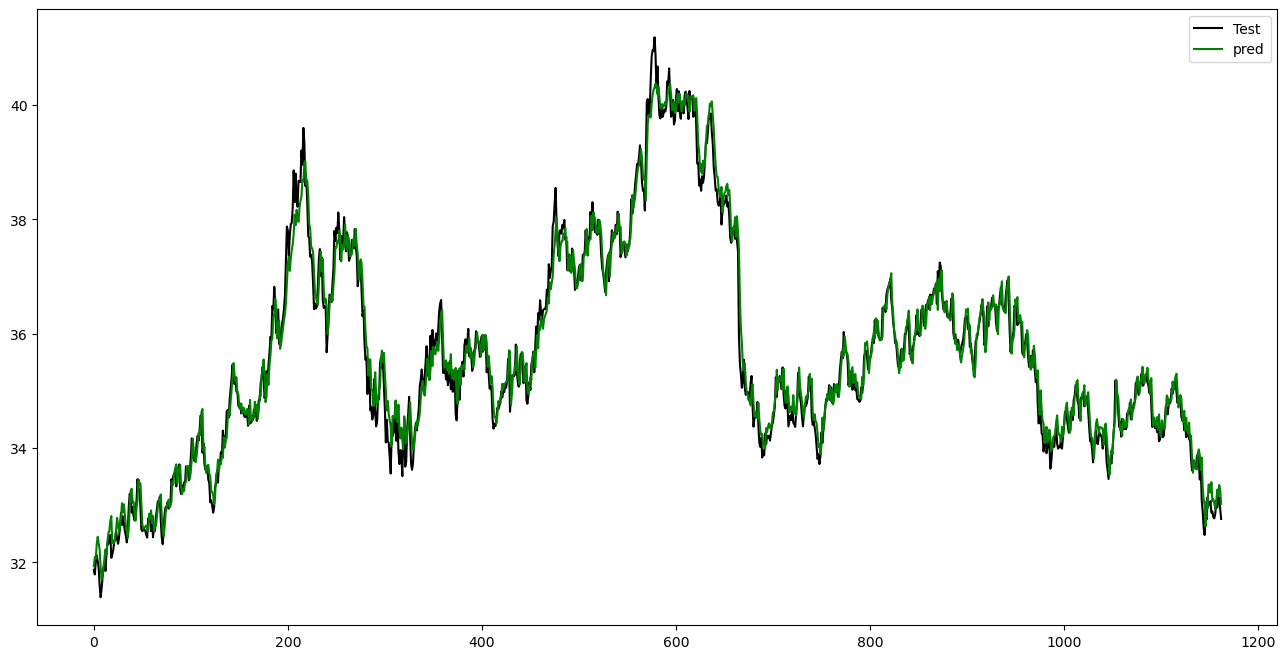

In [19]:
plt.figure(figsize=(16,8))
plt.plot(y_train, color = 'black', label = 'Test')
plt.plot(y_pred_train, color = 'green', label = 'pred')
plt.legend()
plt.show()

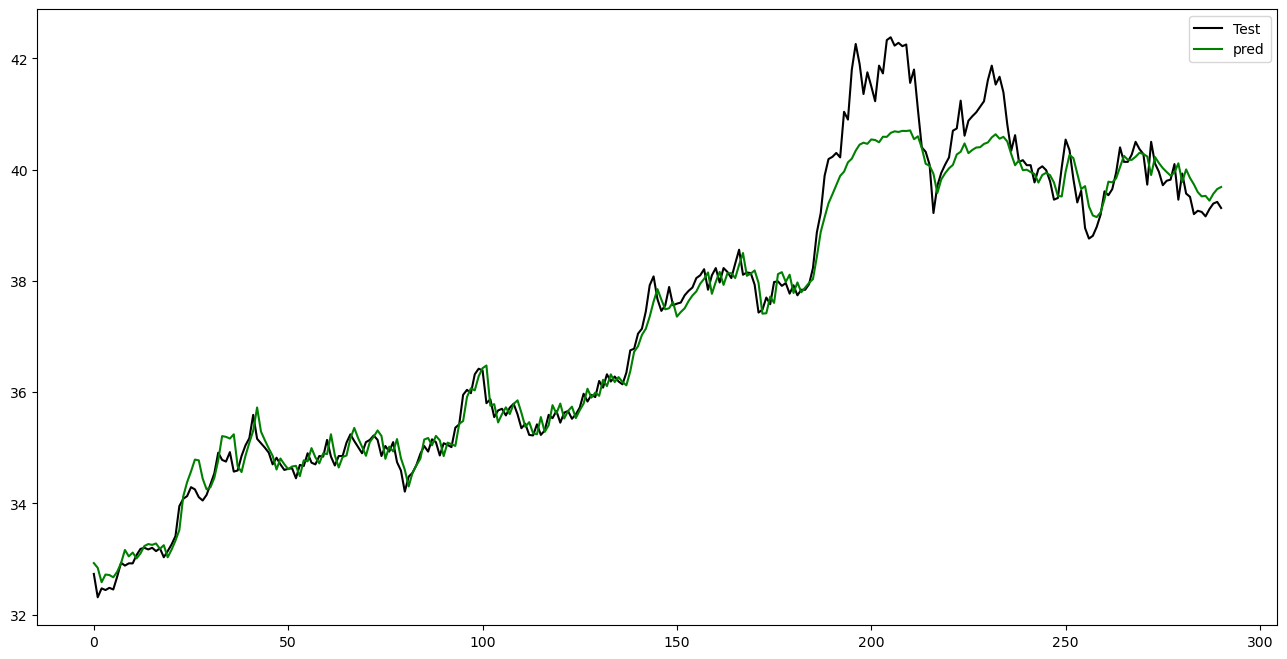

In [20]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred_test, color = 'green', label = 'pred')
plt.legend()
plt.show()

In [21]:
def buy_sell_threshold(current_price, predicted_price, threshold):
    Buy, Sell = [np.nan], [np.nan]

    for i in range(len(predicted_price) - 1):
        if predicted_price[i] / current_price[i] - 1 > threshold:
            Buy.append(current_price[i])
            Sell.append(np.nan)
        elif predicted_price[i] / current_price[i] - 1 < - threshold:
            Sell.append(current_price[i])
            Buy.append(np.nan)
        else:
            Buy.append(np.nan)
            Sell.append(np.nan)
    return Buy, Sell

def generate_dynamic_signals(current_price, predictions, threshold=0.01):
    # Assuming predictions are normalized and centered around 0
    signals = np.zeros(len(predictions))

    for i in range(1, len(predictions)):
        change_percent = (predictions[i] / current_price[i] * 100) -1

        # if change_percent > threshold:
        if abs(change_percent) > threshold:
            # Signal strength is proportional to the change percent
            signals[i] = np.tanh(change_percent)
        else:
            signals[i] = 0
    
    return signals


In [22]:
strategy_data = pd.DataFrame(index=data.index)
strategy_data['Close'] = data['Close']
strategy_data['Date'] = data['Date']
strategy_data['Predictions'] = np.nan
strategy_data['Daily_EFFR'] = data['Daily_EFFR']
strategy_data['Daily_excess_return'] = data['Daily_excess_return'] 

strategy_data.iloc[time_step: time_step+len(y_pred_train), strategy_data.columns.get_loc('Predictions')] = y_pred_train.flatten()
strategy_data.iloc[len(X_train)+time_step:len(X_train)+time_step+len(y_pred_test),strategy_data.columns.get_loc('Predictions')] = y_pred_test.flatten()

strategy_data

,Close,Date,Predictions,Daily_EFFR,Daily_excess_return
0,31.805000,2014-03-14,NaN,3.174603e-08,0.000314
1,31.590000,2014-03-17,NaN,3.174603e-08,-0.006760
2,31.665001,2014-03-18,NaN,3.174603e-08,0.002374
3,31.440001,2014-03-19,NaN,3.174603e-08,-0.007106
4,31.379999,2014-03-20,NaN,3.174603e-08,-0.001908
...,...,...,...,...,...
1455,39.160000,2019-12-23,39.527935,6.150794e-07,-0.002039
1456,39.290001,2019-12-24,39.442951,6.150794e-07,0.003319
1457,39.389999,2019-12-26,39.565807,6.150794e-07,0.002545
1458,39.419998,2019-12-27,39.650772,6.150794e-07,0.000761


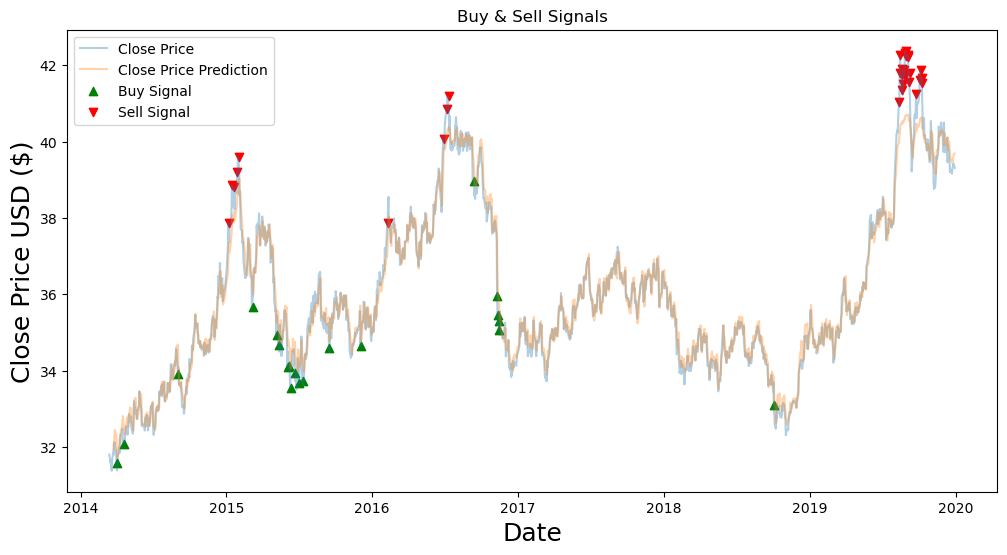

In [23]:

strategy_data['Buy_Signal_Price'], strategy_data['Sell_Signal_Price'] = buy_sell_threshold(strategy_data['Close'], strategy_data['Predictions'], 0.02)

# Plot the buy and sell signals on top of the closing price
plt.figure(figsize=(12,6))
plt.plot(strategy_data['Date'], strategy_data['Close'], label='Close Price', alpha=0.35)
plt.plot(strategy_data['Date'], strategy_data['Predictions'], label='Close Price Prediction', alpha=0.35)
plt.scatter(strategy_data['Date'], strategy_data['Buy_Signal_Price'], label='Buy Signal', marker='^', alpha=1, color='green')
plt.scatter(strategy_data['Date'], strategy_data['Sell_Signal_Price'], label='Sell Signal', marker='v', alpha=1, color='red')
plt.title('Buy & Sell Signals')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend(loc='upper left')

In [24]:
buy_signal = np.where(strategy_data['Buy_Signal_Price'] > 0, 1, 0)
sell_signal = np.where(strategy_data['Sell_Signal_Price'] > 0, -1, 0)
signal = buy_signal + sell_signal
strategy_data['Signal'] = signal
strategy_data

,Close,Date,Predictions,Daily_EFFR,Daily_excess_return,Buy_Signal_Price,Sell_Signal_Price,Signal
0,31.805000,2014-03-14,NaN,3.174603e-08,0.000314,NaN,NaN,0
1,31.590000,2014-03-17,NaN,3.174603e-08,-0.006760,NaN,NaN,0
2,31.665001,2014-03-18,NaN,3.174603e-08,0.002374,NaN,NaN,0
3,31.440001,2014-03-19,NaN,3.174603e-08,-0.007106,NaN,NaN,0
4,31.379999,2014-03-20,NaN,3.174603e-08,-0.001908,NaN,NaN,0
...,...,...,...,...,...,...,...,...
1455,39.160000,2019-12-23,39.527935,6.150794e-07,-0.002039,NaN,NaN,0
1456,39.290001,2019-12-24,39.442951,6.150794e-07,0.003319,NaN,NaN,0
1457,39.389999,2019-12-26,39.565807,6.150794e-07,0.002545,NaN,NaN,0
1458,39.419998,2019-12-27,39.650772,6.150794e-07,0.000761,NaN,NaN,0


/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/plotting_computation.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


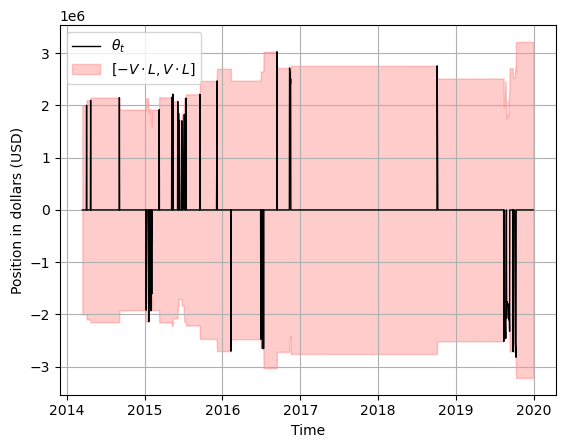

In [31]:
result = compute_position_value(df = strategy_data, 
                                signal = strategy_data['Signal'], 
                                initial_capital = INITIAL_CAP, 
                                max_leverage = LEVERAGE, 
                                reduced_leverage_shorting = False)
plot_position(strategy_data['Date'], result['theta'], result['Vtot'], 10)

/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/plotting_computation.py:63: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


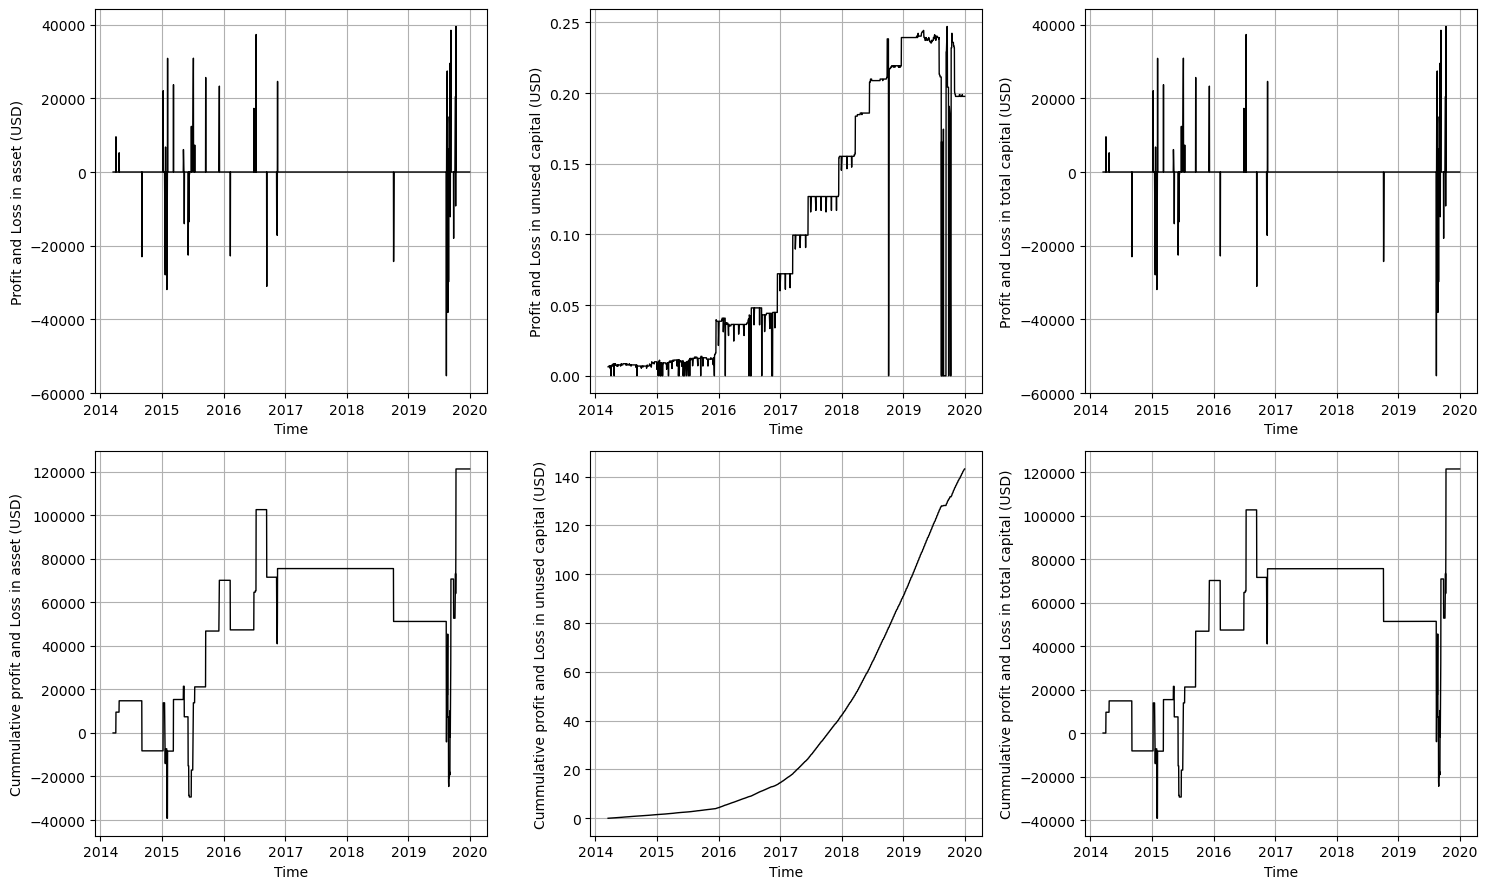

In [32]:
plot_PnL(strategy_data['Date'], result['V'], result['Vcap'], result['Vtot'])

In [33]:
np.cumsum(np.diff(result['Vtot']))[-1]

121421.93054398417

## 3. Get average model performance

In [37]:
cum_pml = []
cum_pml_less_leverage = []

for iteration in range(5):
    model = train_lstm(seed = iteration)
    model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    strategy_data.iloc[time_step: time_step+len(y_pred_train), strategy_data.columns.get_loc('Predictions')] = y_pred_train.flatten()
    strategy_data.iloc[len(X_train)+time_step:len(X_train)+time_step+len(y_pred_test),strategy_data.columns.get_loc('Predictions')] = y_pred_test.flatten()
    strategy_data['Buy_Signal_Price'], strategy_data['Sell_Signal_Price'] = buy_sell_threshold(strategy_data['Close'], strategy_data['Predictions'], 0.02)
    buy_signal = np.where(strategy_data['Buy_Signal_Price'] > 0, 1, 0)
    sell_signal = np.where(strategy_data['Sell_Signal_Price'] > 0, -1, 0)
    signal = buy_signal + sell_signal
    strategy_data['Signal'] = signal
    result = compute_position_value(df = strategy_data, 
                                signal = strategy_data['Signal'], 
                                initial_capital = INITIAL_CAP, 
                                max_leverage = LEVERAGE, 
                                reduced_leverage_shorting = False)
    
    result_less_leverage = compute_position_value(df = strategy_data, 
                            signal = strategy_data['Signal'], 
                            initial_capital = INITIAL_CAP, 
                            max_leverage = LEVERAGE, 
                            reduced_leverage_shorting = True)
    
    cum_pml.append(np.cumsum(np.diff(result['Vtot']))[-1])
    cum_pml_less_leverage.append(np.cumsum(np.diff(result_less_leverage['Vtot']))[-1])
    

Epoch 1/30


2024-03-11 22:10:45.280258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:10:45.489749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:10:45.622590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:10:45.779773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:10:46.008506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 453.6910

2024-03-11 22:10:48.699595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:10:48.779724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:10:48.878719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 7s 43ms/step - loss: 453.6910 - val_loss: 0.5759
Epoch 2/30
70/70 [==============================] - 2s 22ms/step - loss: 3.8781 - val_loss: 2.9095
Epoch 3/30
70/70 [==============================] - 1s 19ms/step - loss: 3.5598 - val_loss: 2.8027
Epoch 4/30
70/70 [==============================] - 1s 20ms/step - loss: 3.5543 - val_loss: 3.2861
Epoch 5/30
70/70 [==============================] - 1s 19ms/step - loss: 3.5581 - val_loss: 3.2164
Epoch 6/30
70/70 [==============================] - 3s 48ms/step - loss: 3.4986 - val_loss: 3.4058
Epoch 7/30
70/70 [==============================] - 3s 35ms/step - loss: 3.3324 - val_loss: 3.1198
Epoch 8/30
70/70 [==============================] - 2s 33ms/step - loss: 1.8271 - val_loss: 0.2572
Epoch 9/30
70/70 [==============================] - 3s 44ms/step - loss: 0.5685 - val_loss: 0.5969
Epoch 10/30
70/70 [==============================] - 2s 26ms/step - loss: 0.5794 - val_loss: 0.1570
Epoch 11/30
70/70 

2024-03-11 22:11:42.692525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:11:42.768708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 5/10 [==============>...............] - ETA: 0s

2024-03-11 22:11:42.906741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 0s 8ms/step
Epoch 1/30


2024-03-11 22:11:45.798171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:11:46.017866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:11:46.119970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:11:46.336906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:11:46.545808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 496.5400

2024-03-11 22:11:48.875799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:11:48.954791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:11:49.073070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 6s 38ms/step - loss: 496.5400 - val_loss: 0.6345
Epoch 2/30
70/70 [==============================] - 1s 20ms/step - loss: 3.8971 - val_loss: 2.4171
Epoch 3/30
70/70 [==============================] - 2s 24ms/step - loss: 3.5790 - val_loss: 2.9146
Epoch 4/30
70/70 [==============================] - 2s 34ms/step - loss: 3.5749 - val_loss: 3.0059
Epoch 5/30
70/70 [==============================] - 1s 21ms/step - loss: 3.5756 - val_loss: 3.0999
Epoch 6/30
70/70 [==============================] - 1s 20ms/step - loss: 3.5689 - val_loss: 3.4011
Epoch 7/30
70/70 [==============================] - 2s 22ms/step - loss: 3.5573 - val_loss: 3.1151
Epoch 8/30
70/70 [==============================] - 1s 21ms/step - loss: 3.5419 - val_loss: 2.8460
Epoch 9/30
70/70 [==============================] - 2s 23ms/step - loss: 3.4924 - val_loss: 3.0086
Epoch 10/30
70/70 [==============================] - 1s 20ms/step - loss: 2.9062 - val_loss: 0.5869
Epoch 11/30
70/70 

2024-03-11 22:12:31.537724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:12:31.619918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:12:31.725246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 0s 10ms/step
Epoch 1/30


2024-03-11 22:12:34.095012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:12:34.349757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:12:34.492683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:12:34.737292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:12:34.946716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 436.7332

2024-03-11 22:12:37.553304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:12:37.639604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:12:37.731400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 5s 42ms/step - loss: 436.7332 - val_loss: 0.5732
Epoch 2/30
70/70 [==============================] - 1s 20ms/step - loss: 3.8382 - val_loss: 2.6480
Epoch 3/30
70/70 [==============================] - 2s 22ms/step - loss: 3.5748 - val_loss: 3.0744
Epoch 4/30
70/70 [==============================] - 2s 23ms/step - loss: 3.5768 - val_loss: 2.8204
Epoch 5/30
70/70 [==============================] - 1s 20ms/step - loss: 3.5696 - val_loss: 2.9461
Epoch 6/30
70/70 [==============================] - 1s 21ms/step - loss: 3.5625 - val_loss: 3.3620
Epoch 7/30
70/70 [==============================] - 1s 20ms/step - loss: 3.5734 - val_loss: 2.7133
Epoch 8/30
70/70 [==============================] - 1s 19ms/step - loss: 3.5726 - val_loss: 2.8490
Epoch 9/30
70/70 [==============================] - 1s 20ms/step - loss: 3.5735 - val_loss: 2.5907
Epoch 10/30
70/70 [==============================] - 1s 19ms/step - loss: 3.6015 - val_loss: 2.9687
Epoch 11/30
70/70 

2024-03-11 22:13:19.557948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:13:19.634313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/10 [==>...........................] - ETA: 6s

2024-03-11 22:13:19.816186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 0s 8ms/step
Epoch 1/30


2024-03-11 22:13:22.394771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:13:22.601302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:13:22.715079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:13:22.900047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:13:23.098876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 390.4232

2024-03-11 22:13:25.717704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:13:25.796192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:13:25.894341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 5s 41ms/step - loss: 390.4232 - val_loss: 3.3029
Epoch 2/30
70/70 [==============================] - 2s 23ms/step - loss: 3.8578 - val_loss: 3.0887
Epoch 3/30
70/70 [==============================] - 1s 20ms/step - loss: 3.5600 - val_loss: 2.3887
Epoch 4/30
70/70 [==============================] - 1s 20ms/step - loss: 3.5628 - val_loss: 2.8417
Epoch 5/30
70/70 [==============================] - 1s 20ms/step - loss: 3.5531 - val_loss: 2.5655
Epoch 6/30
70/70 [==============================] - 1s 19ms/step - loss: 3.5911 - val_loss: 2.3937
Epoch 7/30
70/70 [==============================] - 2s 22ms/step - loss: 3.5946 - val_loss: 2.9335
Epoch 8/30
70/70 [==============================] - 1s 21ms/step - loss: 3.5875 - val_loss: 2.7808
Epoch 9/30
70/70 [==============================] - 1s 20ms/step - loss: 3.5694 - val_loss: 3.0497
Epoch 10/30
70/70 [==============================] - 1s 19ms/step - loss: 3.5663 - val_loss: 2.5570
Epoch 11/30
70/70 

2024-03-11 22:14:08.426913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:14:08.502112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 6/10 [=================>............] - ETA: 0s

2024-03-11 22:14:08.631684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 0s 10ms/step
Epoch 1/30


2024-03-11 22:14:11.440506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:14:11.730953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:14:12.348009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:14:12.727779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:14:12.977528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 495.0542

2024-03-11 22:14:15.423313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:14:15.504500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:14:15.627728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 6s 38ms/step - loss: 495.0542 - val_loss: 5.9426
Epoch 2/30
70/70 [==============================] - 1s 20ms/step - loss: 4.8941 - val_loss: 2.6829
Epoch 3/30
70/70 [==============================] - 1s 20ms/step - loss: 3.5652 - val_loss: 2.6799
Epoch 4/30
70/70 [==============================] - 1s 19ms/step - loss: 3.5701 - val_loss: 3.1165
Epoch 5/30
70/70 [==============================] - 1s 19ms/step - loss: 3.5991 - val_loss: 3.1567
Epoch 6/30
70/70 [==============================] - 1s 19ms/step - loss: 3.5756 - val_loss: 3.1099
Epoch 7/30
70/70 [==============================] - 1s 19ms/step - loss: 3.5820 - val_loss: 2.9971
Epoch 8/30
70/70 [==============================] - 1s 19ms/step - loss: 3.5907 - val_loss: 3.2008
Epoch 9/30
70/70 [==============================] - 1s 19ms/step - loss: 3.6000 - val_loss: 2.3742
Epoch 10/30
70/70 [==============================] - 1s 19ms/step - loss: 3.5514 - val_loss: 3.6014
Epoch 11/30
70/70 

2024-03-11 22:14:55.972208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-11 22:14:56.071897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/10 [==>...........................] - ETA: 5s

2024-03-11 22:14:56.185737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 0s 8ms/step


In [40]:
print(f'Cumulative profit: {cum_pml}')
print(f'Cumulative profit with reduced shorting leverage: {cum_pml_less_leverage}')

Cumulative profit: [73881.86085747974, 232716.30641006387, 272220.96278622985, 85360.90536128695, 68562.13245538768]
Cumulative profit with reduced shorting leverage: [10045.933615688817, 123429.92125964985, 189193.25430395786, 40426.65678181211, 24654.706003209547]


In [42]:
print(f'Mean cumulative profit: {np.mean(cum_pml):3f}')
print(f'Mean cumulative profit with reduced shorting leverage: {np.mean(cum_pml_less_leverage):3f}')

Mean cumulative profit: 146548.433574
Mean cumulative profit with reduced shorting leverage: 77550.094393
